# Cpp Implementaion handler

This notebook is used to load the directory and the .dcm inmages into an array with depth of slices to get a 3D volume array.

The we load the processed csv from the cpp implementation.

And we plot the output comparing to the pywaveltes result.

## Imports

In [68]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Importing the OpenCV library for image processing
import csv

# Importing the pydicom library for reading dicom files
import pydicom
import pywt

## Saving directory to CSV

In [69]:
def get_dicom_files(dcm_dir):
    """Get all DICOM file paths from the specified directory."""
    return [os.path.join(dcm_dir, f) for f in os.listdir(dcm_dir) if f.endswith('.dcm')]

def load_slices_to_volume(dcm_files):
    """Load all DICOM slices and create a 3D volume."""
    # Read the first slice to get the dimensions
    first_slice = pydicom.dcmread(dcm_files[0])
    rows, cols = first_slice.pixel_array.shape

    # Initialize a 3D array to hold all slices
    depth = len(dcm_files)
    volume = np.zeros((depth, rows, cols), dtype=np.float32)

    # Read each slice and add it to the 3D array
    for i, dcm_file in enumerate(dcm_files):
        slice = pydicom.dcmread(dcm_file)
        volume[i, :, :] = slice.pixel_array

    return volume

def save_volume_to_bin(volume, filename):
    """Save the 3D volume to a binary file."""
    depth, rows, cols = volume.shape
    # print the dimensions of the volume
    print("Volume dimensions: {} x {} x {}".format(depth, rows, cols))
    with open(filename, 'wb') as f:
        f.write(np.array([depth, rows, cols], dtype=np.int32).tobytes())  # Write dimensions
        f.write(volume.tobytes())  # Write pixel data

 # Directory containing DICOM files
dcm_dir = 'CHAOS-Test-Sets/CT/3/DICOM_anon'

# Get all DICOM file paths
dcm_files = get_dicom_files(dcm_dir)

# Load all slices and create a 3D volume
input_vol = load_slices_to_volume(dcm_files)

# Save the 3D volume to a .bin file
save_volume_to_bin(input_vol, 'volume.bin')

Volume dimensions: 78 x 512 x 512


Volume shape: (78, 512, 512)


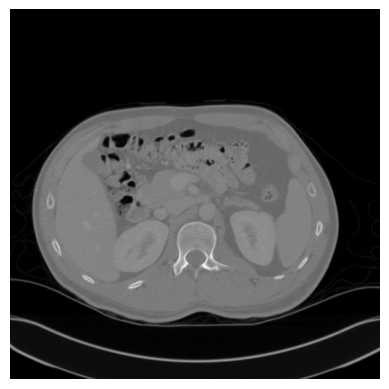

In [70]:
import numpy as np

# Read the volume from the .bin file
with open('volume.bin', 'rb') as f:
    # Read the dimensions
    depth = np.frombuffer(f.read(4), dtype=np.int32)[0]
    rows = np.frombuffer(f.read(4), dtype=np.int32)[0]
    cols = np.frombuffer(f.read(4), dtype=np.int32)[0]
    
    # Read the data
    volume = np.frombuffer(f.read(), dtype=np.float32).reshape((depth, rows, cols))

# Print the shape of the volume
print(f"Volume shape: {volume.shape}")

# Plot the middle slice for verification
plt.imshow(volume[depth // 2, :, :], cmap='gray')
plt.axis('off')
plt.show()

## Loading Cpp processed CSV

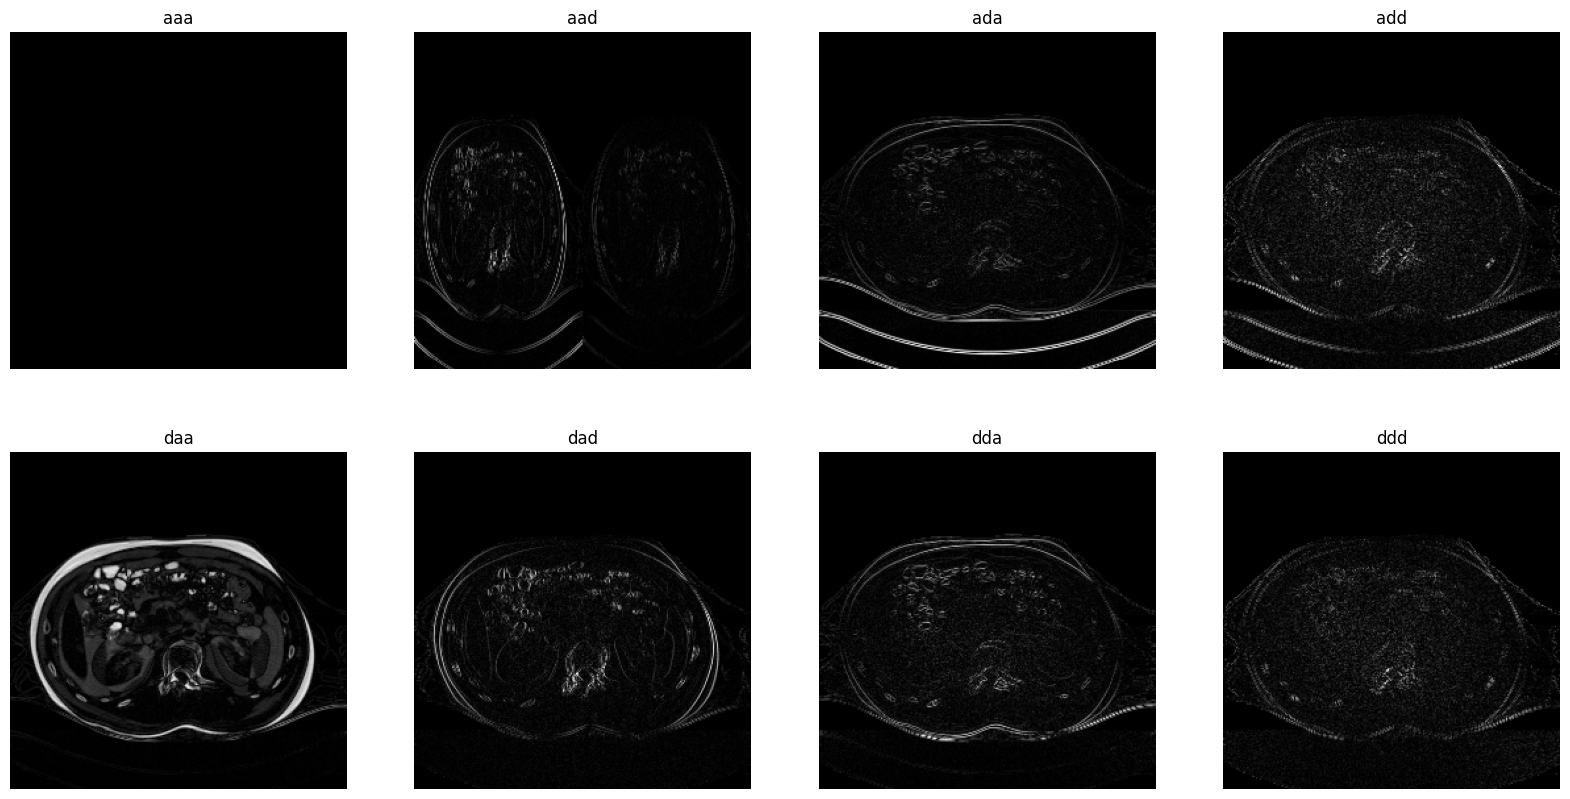

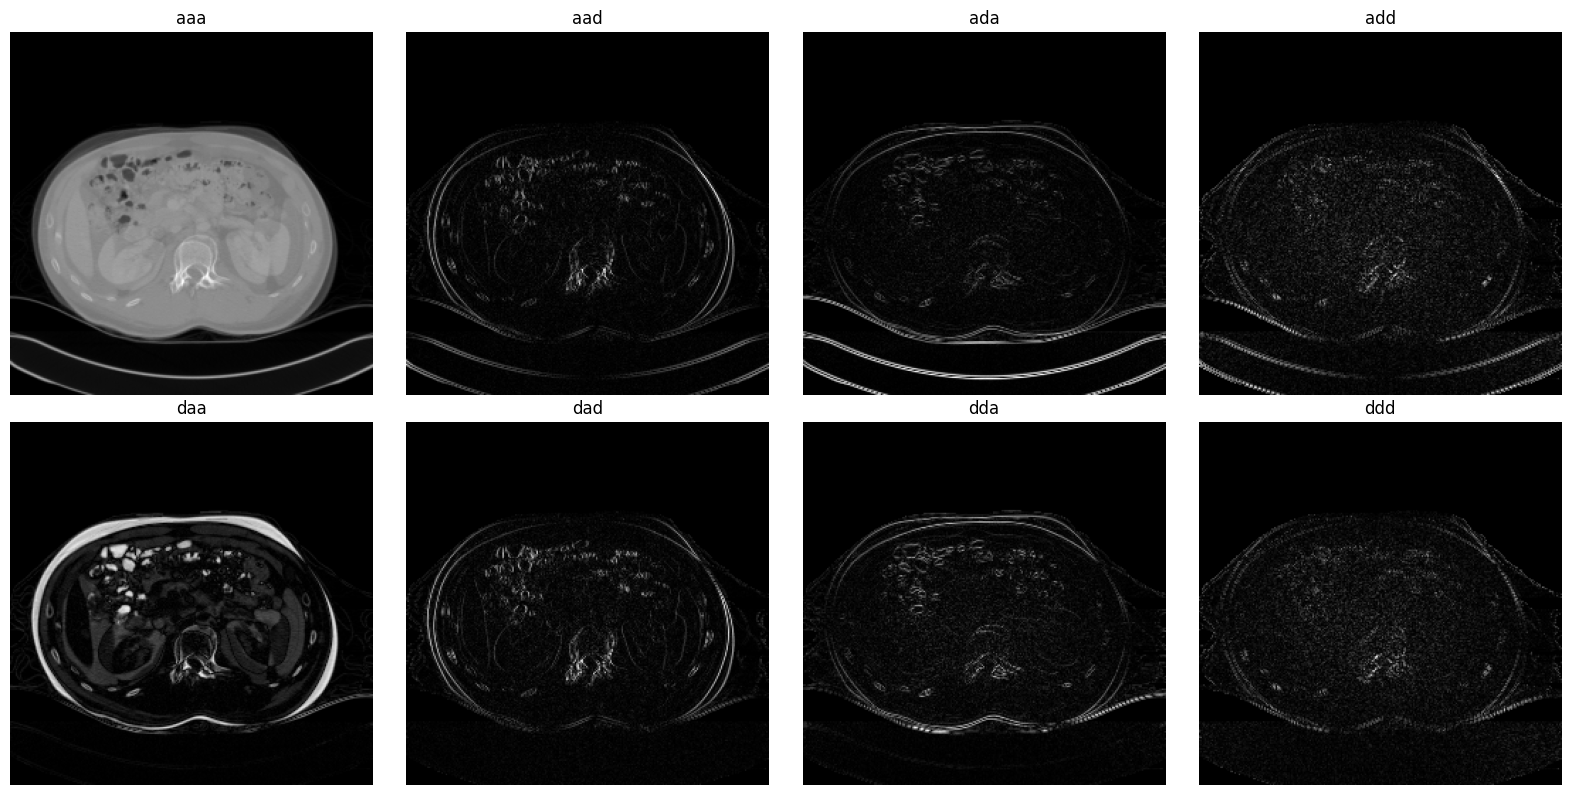

MSE for aaa: 5634103.0
MSE for aad: 9231.2548828125
MSE for ada: 3.311472429601281e-09
MSE for add: 1.5920974538730093e-09
MSE for daa: 3.2067493105358835e-09
MSE for dad: 1.3642098561916782e-10
MSE for dda: 1.7712959987647992e-09
MSE for ddd: 4.6012329363298576e-11


In [73]:
def open_bin_file(filename):
    """Open a binary file and read the volume data."""
        
    with open(filename, 'rb') as f:
        # Read the dimensions
        depth = np.frombuffer(f.read(4), dtype=np.int32)[0]
        rows = np.frombuffer(f.read(4), dtype=np.int32)[0]
        cols = np.frombuffer(f.read(4), dtype=np.int32)[0]
        
        # Read the data
        volume = np.frombuffer(f.read(), dtype=np.float32).reshape((depth, rows, cols))
    return volume

def get_coefficients(volume):
    """The 3D wavelet transform has already been performed on the volume and we want to extract the coefficients."""
    depth = volume.shape[0]
    rows = volume.shape[1]
    cols = volume.shape[2]

    # Initialize a dictionary to hold the coefficients
    coeffs = {}

    # Get the LLL, LLH, LHL, LHH, HLL, HLH, HHL, and HHH subbands
    coeffs['aaa'] = volume[:depth//2, :rows//2, :cols//2]
    coeffs['aad'] = volume[:depth//2, :rows//2, cols//2:]
    coeffs['ada'] = volume[:depth//2, rows//2:, :cols//2]
    coeffs['add'] = volume[:depth//2, rows//2:, cols//2:]
    coeffs['daa'] = volume[depth//2:, :rows//2, :cols//2]
    coeffs['dad'] = volume[depth//2:, :rows//2, cols//2:]
    coeffs['dda'] = volume[depth//2:, rows//2:, :cols//2]
    coeffs['ddd'] = volume[depth//2:, rows//2:, cols//2:]

    return coeffs


def plot_coefficients(coeffs):
    """Plot the subbands of the wavelet coefficients."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    subbands = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
    for i, ax in enumerate(axes.flat):
        subband = subbands[i]
        ax.imshow(coeffs[subband][coeffs[subband].shape[0] // 2, :, :], cmap='gray')
        ax.axis('off')
        ax.set_title(subband)

    plt.show()

# Open the volume from the .bin file
volume = open_bin_file('output.bin')

# Get the wavelet coefficients
coeffs = get_coefficients(volume)

# Take the abs value of the coefficients for visualization
for key in coeffs:
    coeffs[key] = np.abs(coeffs[key])

# Plot the wavelet coefficients
plot_coefficients(coeffs)

### Using the pywt library to perform the 3D wavelet transform on the original input ###

# Using pywavelets to perform the 3D wavelet transform
titles = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
coeffs3 = pywt.dwtn(input_vol, 'haar')

# Take the absolute value of the coefficients to make them easier to visualize
coeffs3 = {key: np.abs(coeffs3[key]) for key in coeffs3}

# Create a composite image to visualize the coefficients
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for ax, title in zip(axes.flatten(), titles):
    ax.imshow(coeffs3[title][coeffs3[title].shape[0] // 2], cmap=plt.cm.gray)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Get the MSE between the two sets of coefficients for each subband
for key in coeffs:
    mse = np.mean((coeffs[key] - coeffs3[key])**2)
    print(f"MSE for {key}: {mse}")
